# Project 3: Parkinson Disease Detection
## Objective: 
The goal of the project is to find suitable feature representations for this problem and compare different classifiers implemented in Python.
## Authors: 
Erlantz Calvo Carrillo
<br> 
Unai Carbajo Escajadillo

In [ ]:
%cd 'pd_datasets//'

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from tpot import TPOTClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn import svm
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, KFold, cross_val_predict
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Data explanation
The data .csv has the next format: \
  X ; Y; Z; Pressure; GripAngle; Timestamp; Test ID

----------------
Test ID: \
0: Static Spiral Test ( Draw on the given spiral pattern) \
1: Dynamic Spiral Test ( Spiral pattern will blink in a certain time, so subjects need to continue on their draw) \
2: Circular Motion Test (Subjectd draw circles around the red point)

# Sources and explanation
Isenkul, Muhammed & Sakar, Betul & Kursun, O.. (2014). Improved Spiral Test Using Digitized Graphics Tablet for Monitoring Parkinson’s Disease. 10.13140/RG.2.1.1898.6005. 

Sakar, Betul & Isenkul, Muhammed & Sakar, C. Okan & Sertbaş, Ahmet & Gurgen, F. & Delil, Sakir & Apaydin, Hulya & Kursun, Olcay. (2013). Collection and Analysis of a Parkinson Speech Dataset With Multiple Types of Sound Recordings. Biomedical and Health Informatics, IEEE Journal of. 17. 828-834. 10.1109/JBHI.2013.2245674. 

[Dataset](https://archive.ics.uci.edu/ml/datasets/Parkinson+Disease+Spiral+Drawings+Using+Digitized+Graphics+Tablet
)

# Loading data
We've got 2 different datasets:
  

*   **Control**: People who did the tests without having the Parkinson disease. 
*   **Parkinson**: People who did the tests having the Parkinson disease. 

*Note:* The parkinson dataset is splitted in two different paths, so we'll load both of them and then mix them up.

In [ ]:
CONTROL_DATASET_PATH = 'hw_dataset/control'
PARKINSON_DATASET_PATH = 'hw_dataset/parkinson'
PARKINSON_DATASET_PATH_2 = 'new_dataset/parkinson'


def load_datasets(control_path, parkinson_path):
  COLUMN_NAMES = ['X', 'Y', 'Z', 'Pressure', 'GripAngle', 'Timestamp', 'Test ID','UserId']
  userid = 0

  #Load Control dataset
  control_files = os.listdir(control_path)
  df_control = pd.DataFrame(columns=COLUMN_NAMES)
 
  for i in tqdm(range(len(control_files)), desc= 'Control files: ', unit=' files'):
    new_user_path = os.path.join(control_path, control_files[i])
    new_user = pd.read_csv(new_user_path, header=None,  sep=';', names=COLUMN_NAMES)
    new_user['UserId'] = userid
    df_control = df_control.append(new_user)
    userid +=1


  #Load parkinson dataset
  parkinson_files = os.listdir(parkinson_path)
  df_parkinson = pd.DataFrame(columns=COLUMN_NAMES)

  for j in tqdm(range(len(parkinson_files)), desc= 'Parkinson files: ', unit=' files'):
    new_user_path = os.path.join(parkinson_path, parkinson_files[j])  
    new_user = pd.read_csv(new_user_path, header=None,  sep=';',names=COLUMN_NAMES)
    new_user['UserId'] = userid
    df_parkinson = df_parkinson.append(new_user)
    userid +=1

  parkinson_files =  os.listdir(PARKINSON_DATASET_PATH_2)
  for k in tqdm(range(len(parkinson_files)), desc= 'Parkinson files: ', unit=' files'):
    new_user_path = os.path.join(PARKINSON_DATASET_PATH_2, parkinson_files[i])  
    new_user = pd.read_csv(new_user_path, header=None,  sep=';')
    new_user['UserId'] = userid
    df_parkinson = df_parkinson.append(new_user)
    userid +=1


  return df_parkinson, df_control
df_parkinson, df_control= load_datasets(CONTROL_DATASET_PATH, PARKINSON_DATASET_PATH)

Parkinson files: 100%|██████████| 37/37 [00:03<00:00,  9.30 files/s]


# Test visualization
Here we can see some of the subjects tests from the given data. On the left the control subjects and, on the right, the Parkinson disease subjects. 

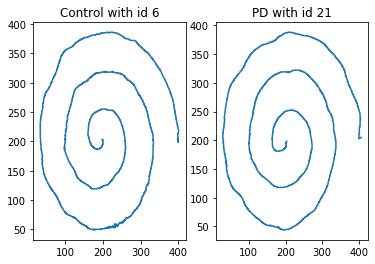

In [ ]:
# Number of samples to be displayed
n_samples = 3

# Test id to be displayed
test_num = 0

for _ in range(n_samples):
    uid= np.random.randint(0,14)

    # Control sample
    plt.figure()
    x_draw = df_control[(df_control['UserId']==uid) & (df_control['Test ID']==test_num)]
    y_draw = x_draw['Y'].to_list()
    x_draw = x_draw['X'].to_list()
    plt.subplot(1,2,1)
    plt.plot(x_draw, y_draw)
    plt.title('Control with id {}'.format(uid))

    # PD sample
    x_draw_p = df_parkinson[(df_parkinson['UserId'] == (uid+15)) & (df_parkinson['Test ID'] == test_num)]
    y_draw_p = x_draw_p['Y'].to_list()
    x_draw_p = x_draw_p['X'].to_list()
    plt.subplot(1,2,2)
    plt.plot(x_draw_p, y_draw_p)
    plt.title('PD with id {}'.format(uid+15))
    plt.show()

# Getting variable variation
We extract how much does a certain variable change through the time along all the dataset. These new variables represent the change of certain value (pressure, grip angle, coordinates) from one sample to another.

New variables:
- **GripAngleDelta**: sum of the changes of the grip angle of the pen.
- **PressureDelta**: sum of the change* of the applied pressure on the pen. The grip Z value is also taken as a preassure because 
  if user's pulse trembles he may raise his hand.
- **CoordDelta**: sum changes of the coordenates of the pen.

*'change' represents the substraction between a measure in a 't+1' time and another measure in a 't' time.*

In [ ]:
def get_subject_deltas(subject_data):
  subject_grip_angle_delta = 0
  subject_pressure_delta = 0
  subject_coord_delta = 0
  for i in range(len(subject_data) - 1):
    # Grip angle variation
    subject_grip_angle_delta += abs(subject_data['GripAngle'].iloc[i + 1] - subject_data['GripAngle'].iloc[i])
    
    # Pressure variation
    subject_pressure_delta += abs(subject_data['Pressure'].iloc[i + 1] - subject_data['Pressure'].iloc[i])
    subject_pressure_delta += abs(subject_data['Z'].iloc[i + 1] - subject_data['Z'].iloc[i])

    # Coordinates angle variation
    subject_coord_delta+= abs(subject_data['X'].iloc[i + 1] - subject_data['X'].iloc[i]) + abs(subject_data['Y'].iloc[i + 1] - subject_data['Y'].iloc[i]) + abs(subject_data['Z'].iloc[i + 1] - subject_data['Z'].iloc[i])

  return subject_grip_angle_delta, subject_pressure_delta, subject_coord_delta

# Final dataset preparation
We prepare the final dataset to be trained and tested, so we will do some feature extraction and join the control dataset and the parkinson dataset.

Once taken the new features, we construct new statistic ones based on the variance and the std. deviation of the pressure, angle and coordinates:

- **GripAngleVariance**
- **GripAngleStd**
- **PressureVariance**
- **PressureStd**


In [ ]:
def extract_features(dataset, subjects, is_parkinson):
  NEW_COLUMNS = ['UserID', 'CoordinatesDelta',  'SameCoordDelta','GripAngleVariance', 'GripAngleStd', 'GripAngleDelta', 'GripAngleZscore', 'PressureVariance', 'PressureStd', 'PressureDelta', 'PressureZscore', 'Duration', 'Test ID', 'Parkinson']
  df_polished = pd.DataFrame(columns=NEW_COLUMNS)

  # Loop to iterate over the 3 possible tests
  for i in range(3):

    # Loop to iterate over all the subjects passed as argument
    for j in tqdm(range(len(subjects)), desc=f'Test {i}: '):
      df_subject = dataset[(dataset['Test ID'] ==i) & (dataset['UserId']==subjects[j])]
      
      if len(df_subject)>0:
        #insert new values to the dataset
        angle_variance = df_subject['GripAngle'].var()
        angle_st_deviation = df_subject['GripAngle'].std()

        pressure_variance =  df_subject['Pressure'].var()
        pressure_st_deviation = df_subject['Pressure'].std()

        # Getting de current test duration (end time - start time)
        start_time = df_subject['Timestamp'].iloc[0]
        end_time = df_subject['Timestamp'].iloc[-1]
        duration = end_time - start_time

        # Get all the variations and divide them by the time to have all the subjects in the same
        # variation/time relationship
        grip_angle_delta, pressure_delta, coord_delta = get_subject_deltas(df_subject)
        grip_angle_delta = grip_angle_delta / duration
        pressure_delta = pressure_delta / duration
        coord_delta = coord_delta / duration

        # Getting how many times the user is in the same coord (X,Y,Z)
        same_coord_delta = df_subject.groupby(['X', 'Y', 'Z']).size().reset_index(name='count').sum()['count'] / duration

        if not angle_st_deviation == 0:
          angle_zscore = (grip_angle_delta - df_subject['GripAngle'].mean())/angle_st_deviation
        else:
          angle_zscore =  0

        if not pressure_st_deviation == 0:
          pressure_zscore = (pressure_delta - df_subject['Pressure'].mean())/pressure_st_deviation
        else:
          pressure_zscore = 0
        

        df_polished = df_polished.append({'UserID': int(subjects[j]), 'CoordinatesDelta' : coord_delta, 'SameCoordDelta': same_coord_delta, 'GripAngleVariance' : angle_variance, 
                                          'GripAngleStd' : angle_st_deviation, 'GripAngleDelta' : grip_angle_delta, 'GripAngleZscore': angle_zscore,
                                          'PressureVariance' : pressure_variance, 'PressureStd' : pressure_st_deviation, 
                                          'PressureDelta' : pressure_delta, 'PressureZscore': pressure_zscore, 'Duration' : duration, 'Test ID' : i, 'Parkinson' : is_parkinson}, 
                                         ignore_index = True)
        df_polished[['UserID', 'Duration', 'Test ID', 'Parkinson']] =  df_polished[['UserID', 'Duration', 'Test ID', 'Parkinson']].astype(int)
  return df_polished

def prepare_dataset(control_dataset, parkinson_dataset):
  # Get all control users id
  control_users_id = control_dataset['UserId'].unique()
  control_polished = extract_features(control_dataset, control_users_id, 0)

  # Get all PD users id
  parkinson_users_id = parkinson_dataset['UserId'].unique()
  parkinson_polished = extract_features(parkinson_dataset, parkinson_users_id, 1)

  frames = [control_polished, parkinson_polished]
  final_dataset = pd.concat(frames)

  # Make a one hot encoding to the test id column because there are values between 0 and 2 and, when multiplying
  # this variables with a weight or a given value, the 3rd test will always have more importance than the other two
  # and that's not the idea
  one_hot = pd.get_dummies(final_dataset['Test ID'], prefix='Test_ID')
  
  final_dataset = pd.concat([final_dataset, one_hot], axis=1, sort=False)
  final_dataset = final_dataset.drop('Test ID', axis=1)
  
  return final_dataset
final_dataset = prepare_dataset(df_control, df_parkinson)
final_dataset

Test 2: 100%|██████████| 62/62 [00:05<00:00, 10.68it/s]


,UserID,CoordinatesDelta,SameCoordDelta,GripAngleVariance,GripAngleStd,GripAngleDelta,GripAngleZscore,PressureVariance,PressureStd,PressureDelta,PressureZscore,Duration,Parkinson,Test_ID_0,Test_ID_1,Test_ID_2
0,0,0.343655,0.142158,24859.868842,157.670127,2.061069,-5.216415,7093.398992,84.222319,0.565390,-10.885275,13886,0,1,0,0
1,1,0.232262,0.111055,12158.831112,110.267090,0.550915,-8.188765,3477.196396,58.967757,0.321972,-14.299815,35559,0,1,0,0
2,2,0.323166,0.142146,14560.734773,120.667870,1.158012,-6.727004,3771.980803,61.416454,0.501376,-14.383046,17081,0,1,0,0
3,3,0.251607,0.138546,14645.790713,121.019795,1.027755,-17.084962,25743.258991,160.447060,0.654768,-3.093385,13223,0,1,0,0
4,4,0.141986,0.142113,22162.988710,148.872391,0.646752,-9.279447,4067.676182,63.778336,0.337155,-9.683029,39335,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,35,0.595638,0.107379,9071.367686,95.243728,1.347038,-12.392610,0.000000,0.000000,0.519930,0.000000,11967,1,0,0,1
69,36,0.265566,0.112833,25274.279565,158.978865,0.839751,-7.995099,89211.575400,298.683068,0.504779,-2.416703,10777,1,0,0,1
70,37,0.327847,0.128633,4711.990537,68.643940,1.130587,-17.431242,36321.531088,190.582085,0.537035,-1.007059,38396,1,0,0,1
71,38,0.333184,0.112948,1705.631521,41.299292,0.587654,-33.750780,99591.023764,315.580455,0.641477,-2.414093,11129,1,0,0,1


# Data visualization
Here will be shown the comparative of the control subjects and PD subjects over the time (X axis = test duration, Y axis = user's data value).
\
Control subjects are printed in blue and PD subjects in red.

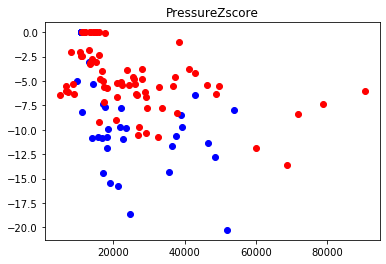

In [ ]:
# Separate Control users data and PD users data
control_data = final_dataset[final_dataset['Parkinson']==0].drop(['UserID', 'Parkinson', 'Test_ID_0','Test_ID_1','Test_ID_2'],1)
parkinson_data = final_dataset[final_dataset['Parkinson']==1].drop(['UserID', 'Parkinson', 'Test_ID_0','Test_ID_1','Test_ID_2'],1)

# Get Control users test duration and PD users test duration
control_duration = control_data['Duration']
parkinson_duration = parkinson_data['Duration']

# Show all the variable's comparative
for col in control_data.drop(['Duration'],1).columns:
  plt.figure()
  control_col = control_data[col]
  parkinson_col = parkinson_data[col]
  plt.plot(control_duration, control_col, 'bo', parkinson_duration, parkinson_col, 'ro')
  plt.title(col)
  plt.show()

# Prepare the training and test datasets
We split the final dataset in two new datasets, train and test. Since we have an unbalanced dataset
we have split the dataset with a stratified method for having the most balanced train and test dataset that is possible.

We have chosen to split the data in 66% for training and 33% for testing.


In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_dataset.drop(['UserID', 'Parkinson'],1))

#split the data into two datasets and remove the columns that are not valid for the prediction
trainX, testX, trainY, testY = train_test_split(scaled_data,
final_dataset['Parkinson'], test_size=0.2, stratify=final_dataset['Parkinson'])

print(f'Train:\nControl: {trainY.value_counts()[0]}\n Parkinson: {trainY.value_counts()[1]}')
print(f'Test:\nControl: {testY.value_counts()[0]}\n Parkinson: {testY.value_counts()[1]}')

Train:
Control: 30
 Parkinson: 58
Test:
Control: 7
 Parkinson: 15


# Logistic regression classifier

In [ ]:
lr = LogisticRegression(max_iter=500)
lr.fit(trainX, trainY)
prediction = lr.predict(testX)
print(f'Accuracy: {accuracy_score(testY, prediction)}')
print(f'Balanced Accuracy: {balanced_accuracy_score(testY, prediction)}')
confusion_matrix(testY, prediction)

Accuracy: 1.0
Balanced Accuracy: 1.0


array([[ 7,  0],
       [ 0, 15]])

# Random forest classifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(trainX, trainY)
prediction = rf.predict(testX)
print(f'Accuracy: {accuracy_score(testY, prediction)}')
print(f'Balanced Accuracy: {balanced_accuracy_score(testY, prediction)}')
confusion_matrix(testY, prediction)

Accuracy: 1.0
Balanced Accuracy: 1.0


array([[ 7,  0],
       [ 0, 15]])

# Support Vector Machine classifier

In [ ]:
svc = svm.NuSVC()
svc.fit(trainX, trainY)
prediction = svc.predict(testX)
print(f'Accuracy: {accuracy_score(testY, prediction)}')
print(f'Balanced Accuracy: {balanced_accuracy_score(testY, prediction)}')
confusion_matrix(testY, prediction)

Accuracy: 1.0
Balanced Accuracy: 1.0


array([[ 7,  0],
       [ 0, 15]])

# TPOT classifier
The TPOT classifier try to find the best classifier for the dataset given with it's best pipelines* with genetic algorithms. This classifier is usually optimum but it
has a very expensive computational weight.

<img alt="Tpot scheme" src="https://raw.githubusercontent.com/EpistasisLab/tpot/master/images/tpot-ml-pipeline.png" width="75%">

*A pipeline consists of a sequence of components which are a compilation of computations. Data is sent through these components and is manipulated with the help of computation.

In [ ]:
tpot = TPOTClassifier(generations=5,  verbosity=2)
tpot.fit(trainX, trainY)


Generation 1 - Current best internal CV score: 1.0
Generation 2 - Current best internal CV score: 1.0
Generation 3 - Current best internal CV score: 1.0
Generation 4 - Current best internal CV score: 1.0
Generation 5 - Current best internal CV score: 1.0
Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=1.0, max_depth=4, max_features=0.9000000000000001, min_samples_leaf=5, min_samples_split=9, n_estimators=100, subsample=0.8500000000000001)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=5,
               log_file=<ipykernel.iostream.OutStream object at 0x7efebc640410>,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [ ]:
prediction = tpot.predict(testX)
print(f'Accuracy: {accuracy_score(testY, prediction)}')
print(f'Balanced Accuracy: {balanced_accuracy_score(testY, prediction)}')
confusion_matrix(testY, prediction)

Accuracy: 1.0
Balanced Accuracy: 1.0


array([[ 7,  0],
       [ 0, 15]])

## EVALUATING CLASSIFIERS
#### Facing unbalanced dataset problem

This dataset is highly unbalanced when it comes to class distribution. Thus, for evaluating the classifiers we used 
the **Stratified K-Folds cross-validator** (with k = 10) along with a **balanced accuracy score**. This type of k-fold cross-validator let us
split the the train set in k stratified folds that preserve the percentage of samples for each class, leaving fairer
folds, and, for evaluating the performance of each classifier, we used the balanced accuracy score, that is defined as the 
average of recall obtained on each class.

<br><br>
<img src = https://miro.medium.com/max/562/0*QKJTHrcriSx2ZNYr.png>


##### Source: https://medium.com/@xzz201920/stratifiedkfold-v-s-kfold-v-s-stratifiedshufflesplit-ffcae5bfdf

In [ ]:
k = 10
strat_kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
svc = svm.SVC()
rf = RandomForestClassifier()
lr= LogisticRegression(max_iter=500)

svc_ba_sum = 0
rf_ba_sum = 0
lr_ba_sum = 0

# Enumerize subdatasets (equaly distributed)
for train_index, test_index in strat_kfold.split(trainX, trainY):
    # print("TRAIN:", train_index, "TEST:", test_index)
    train_x, test_x = trainX[train_index], trainX[test_index]
    train_y, test_y = trainY.iloc[train_index], trainY.iloc[test_index]
    split_perc = 100*len(train_y[train_y==0])/len(train_y)
    print("TRAIN PERCENTAGES. 0's: {:.4}%\t 1's: {:.4}%".format(split_perc, 100-split_perc))

    ## Fit classifiers
    svc.fit(train_x, train_y)
    rf.fit(train_x, train_y)
    lr.fit(train_x, train_y)

    ## Predict
    svc_prediction = svc.predict(test_x)
    rf_prediction = rf.predict(test_x)
    lr_prediction = lr.predict(test_x)

    ## Compare several balanced accuracies
    rf_sc = balanced_accuracy_score(test_y, rf_prediction)
    svc_sc = balanced_accuracy_score(test_y,svc_prediction) 
    lr_sc = balanced_accuracy_score(test_y,lr_prediction) 

    rf_ba_sum += rf_sc
    svc_ba_sum += svc_sc
    lr_ba_sum += lr_sc
    print("Balanced accuracy\t[SVC]: {:.3}\t [RF]:{:.3}\t [LR]:{:.3}".format(svc_sc,rf_sc,lr_sc))

print("[SVC]: {:.4} \t [RF] {:.4} \t [LR] {:.4}".format(svc_ba_sum/k, rf_ba_sum/k, lr_ba_sum/k))

TRAIN PERCENTAGES. 0's: 34.18%	 1's: 65.82%
Balanced accuracy	[SVC]: 1.0	 [RF]:1.0	 [LR]:1.0
TRAIN PERCENTAGES. 0's: 34.18%	 1's: 65.82%
Balanced accuracy	[SVC]: 0.917	 [RF]:0.667	 [LR]:0.917
TRAIN PERCENTAGES. 0's: 34.18%	 1's: 65.82%
Balanced accuracy	[SVC]: 1.0	 [RF]:0.833	 [LR]:1.0
TRAIN PERCENTAGES. 0's: 34.18%	 1's: 65.82%
Balanced accuracy	[SVC]: 1.0	 [RF]:1.0	 [LR]:1.0
TRAIN PERCENTAGES. 0's: 34.18%	 1's: 65.82%
Balanced accuracy	[SVC]: 1.0	 [RF]:1.0	 [LR]:1.0
TRAIN PERCENTAGES. 0's: 34.18%	 1's: 65.82%
Balanced accuracy	[SVC]: 1.0	 [RF]:1.0	 [LR]:1.0
TRAIN PERCENTAGES. 0's: 34.18%	 1's: 65.82%
Balanced accuracy	[SVC]: 1.0	 [RF]:1.0	 [LR]:1.0
TRAIN PERCENTAGES. 0's: 34.18%	 1's: 65.82%
Balanced accuracy	[SVC]: 1.0	 [RF]:0.917	 [LR]:1.0
TRAIN PERCENTAGES. 0's: 33.75%	 1's: 66.25%
Balanced accuracy	[SVC]: 0.667	 [RF]:0.667	 [LR]:0.667
TRAIN PERCENTAGES. 0's: 33.75%	 1's: 66.25%
Balanced accuracy	[SVC]: 1.0	 [RF]:1.0	 [LR]:1.0
[SVC]: 0.9583 	 [RF] 0.9083 	 [LR] 0.9583


## Leave One Out Cross-Validation
We selected another method for the model validation task, in this case we have chosen the Leave One Out Cross-Validation 
method, which, speaking about computational capacity, is very expensive but is a very good method for the model evaluation too.
### Explanation
The models will be trained with all the dataset except one instance and will be tested with that intance left.  This will be repeated with all de intances in the dataset.\
<br><br>
<img src = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/LOOCV.gif/300px-LOOCV.gif">

In [ ]:
# Prepare de X and Y datasets, removing the class column from the X variable and other 
# unnecesary columns

cross_val_Y = final_dataset['Parkinson']
cross_val_X = scaled_data
n_samples = cross_val_X.shape[0]

# Evaluate all the models created with the Leave One Out Cross-Validation method.

lr_predictions = cross_val_predict(lr, cross_val_X, cross_val_Y, cv = KFold(n_samples))
print(f'Logistic regression accuracy: {accuracy_score(cross_val_Y,lr_predictions)}')
print(f'Logistic regression confusion matrix:\n {confusion_matrix(cross_val_Y,  lr_predictions)}\n')

svc_predictions = cross_val_predict(svc, cross_val_X, cross_val_Y, cv = KFold(n_samples))
print(f'Support Vector Machine accuracy: {accuracy_score(cross_val_Y,svc_predictions)}')
print(f'Support Vector Machine confusiion matrix:\n {confusion_matrix(cross_val_Y,  svc_predictions)}\n')

rf_predictions = cross_val_predict(rf, cross_val_X, cross_val_Y, cv = KFold(n_samples))
print(f'Random Forest accuracy: {accuracy_score(cross_val_Y,rf_predictions)}')
print(f'Random Forest confusion matrix:\n {confusion_matrix(cross_val_Y,  rf_predictions)}\n')

tpot_predictions = cross_val_predict(tpot.fitted_pipeline_, cross_val_X, cross_val_Y, cv = KFold(n_samples))
print(f'Tpot accuracy: {accuracy_score(cross_val_Y,tpot_predictions)}')
print(f'Tpot confusion matrix:\n {confusion_matrix(cross_val_Y,  tpot_predictions)}')

Logistic regression accuracy: 0.9727272727272728
Logistic regression confusion matrix:
 [[35  2]
 [ 1 72]]

Support Vector Machine accuracy: 0.9727272727272728
Support Vector Machine confusiion matrix:
 [[35  2]
 [ 1 72]]

Random Forest accuracy: 0.9818181818181818
Random Forest confusion matrix:
 [[35  2]
 [ 0 73]]

Tpot accuracy: 0.990909090909091
Tpot confusion matrix:
 [[36  1]
 [ 0 73]]
